<a href="https://colab.research.google.com/github/dainis-boumber/av/blob/master/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ULMFiT + Siamese Network for Sentence Vectors
## Part Three: Classifying

The second notebook created a new language model from the SNLI dataset.
This notebook will adapt that model to predicting the SNLI category for sentence pairs.
The model will be used as a sentence encoder for a Siamese Network that builds sentence vectors that are feed into a classifier network.

In [3]:
from ipyexperiments import *
import fastai
from fastai.text import *
import html
import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
import random
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
import data
import joblib

token_files = './data/PAN14/tokens/'
model_files = './data/PAN14/models/'
TRAINDATAPATH = "./data/PAN14/pan14_train_english-essays/"
TESTDATAPATH = "./data/PAN14/pan14_test02_english-essays/"
FNAMES = ['known01','known02','known03','known04','known05', 'unknown']
KCOLS=['known01','known02','known03','known04','known05']
LABELCOL="answer"
UNKOWN="unknown"

path = model_files
name_gen = 'gen/'
path_gen = './data/PAN14/models/gen/'
path_crit = './data/PAN14/models/crit/'
doc_pairs_train=joblib.load(f'{model_files}traindf-1.pkl')
doc_pairs_val=joblib.load(f'{model_files}valdf-1.pkl')
doc_pairs_test=joblib.load(f'{model_files}testdf-1.pkl')

UsageError: Line magic function `%autoreload` not found.


In [2]:
doc_pairs_train.head()

NameError: name 'doc_pairs_train' is not defined

In [113]:
def create_gen_learner(lm):
    #return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
    #                     self_attention=True, y_range=y_range, loss_func=loss_gen)
    return fastai.text.language_model_learner(lm, drop_mult=0.7, metrics=[accuracy], )

In [114]:
data_lm = TextLMDataBunch.from_df(model_files, doc_pairs_train, doc_pairs_val, text_cols=['known', 'unknown'],
                                  label_cols=['label'], mark_fields=True, bs=64)

learn_gen = create_gen_learner(data_lm)

In [117]:
learn_gen.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy
1,6.088506,5.940187,0.068583


In [118]:
learn_gen.unfreeze()

In [119]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy
1,5.852700,5.705071,0.105539
2,5.647752,5.571455,0.125270
3,5.600340,5.538517,0.127555


In [120]:
learn_gen.save('learn-gen-a')
learn_gen.load('learn-gen-a')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (529 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/PAN14/models
x: LMTextList (529 items)
[Text xxbos xxfld 1 ﻿ xxmaj english , my xxmaj english ! xxmaj xxunk ones strengths and weaknesses in any situation is a hard task . xxmaj usually we are not so good at xxunk our strengths , instead we spend our time being critical of ourselves , thus we tend to present a much more detailed side of our flaws . i will try to give you a reasonable picture of my good and not quite as good sides , as i see them , in reference to the four skills that were mentioned in the guide - lines handed out earlier in regard of this essay . y biggest weakness by far is reading in xxmaj english . i most of the time find it quite boring , it probably has to do with the fact that i 'm a very outgoing person and therefore i like meeting people and i prefer to converse with them . a contributing factor to my feelings

In [138]:
def generate(dl, n=10, n_words=70, writeout=False):
    preds=[]
    i=0

    for k, u in dl:
        show_xyzs
        predict = learn_gen.predict(text=data_lm.b, n_words=n_words, )
        i+=1
        s=''.join(predict[2:])
        preds.append(s)
        if writeout:
            with open(path_gen+'gen'+str(i)+'.txt', 'w') as f:
                f.write(s)
        if i == n:
            break
    
    return preds

generated=generate(data_lm.dl..fix_dl, 3, 15)
print(generated)

[' of who we be is to well about and i accomplishments the on . of', ' has useless their , may the and liked too their that especially the decide -', ' , a where . thing think about . is a - an the are to']


In [ ]:
data_crit = generated()

In [ ]:
def create_critic_learner(data, loss, metrics, drop_mult=0.7, qrnn=False):
    default_dropout = {'language': np.array([0.25, 0.1, 0.2, 0.02, 0.15]),
                   'classifier': np.array([0.4,0.5,0.05,0.3,0.4])}
    dps = default_dropout['classifier'] * drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]
    vocab_size, n_class = len(data.vocab.itos), data.c
    layers = [emb_sz*3] + lin_ftrs + [n_class]
    ps = [dps[4]] + ps
    crit_model = get_rnn_classifier(bptt=70, max_len=70*20, vocab_size, emb_sz=400, nh=1150, nl=3, pad_token=1,
                layers, ps, input_p=dps[0], weight_p=dps[1], embed_p=dps[2], hidden_p=dps[3], qrnn=qrnn)
    return Learner(data, crit_model, metrics=metrics, loss_func=loss, wd=1e-3)

In [ ]:
learn_crit = create_critic_learner(data_crit, loss_critic, accuracy_thresh_expand)

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [5]:
data_clf = TextClasDataBunch.from_df(model_files, doc_pairs_train, doc_pairs_val, doc_pairs_test,
                                vocab=data_lm.train_ds.vocab, bs=64,
                                  text_cols=['known', 'unknown'], label_cols=['label'], mark_fields=True)



In [6]:
data_clf.save()          
data_clf = TextClasDataBunch.load(model_files, bs=64)

In [7]:
learn = text_classifier_learner(data_clf, drop_mult=0.5)
learn.load_encoder('healthy_enc')

In [8]:
data_clf.show_batch()

text,target
xxbos xxfld 1 xxmaj carrycot xxmaj carry - out \ s \ s \ s \ ssweet xxmaj cotton xxmaj candy \ s \ s \ s \ sbaby carriage xxmaj pushcart xxmaj formula \ s \ s \ s \ sbassinet xxmaj baggage car xxmaj billfold xxmaj barfly \ s \ s \ s \ sbre xxmaj checkerboard xxmaj draughtboard xxmaj checking account xxmaj current,1
xxbos xxfld 1 xxmaj catapult edian strip xxmaj central reservation xxmaj certified mail xxmaj recorded delivery xxmaj channel surf xxmaj channel hop xxup cpa \ s \ s \ s \ sholdall xxmaj portacrib \ s \ s \ s \ samerican football xxmaj video arcade xxmaj amusement arcade \ s \ s \ s \ stin xxmaj canadian bacon xxmaj bacon xxmaj candy \,1
xxbos xxfld 1 xxmaj babymilk xxmaj babysitter \ s \ s \ s \ sholdall xxmaj portacrib \ s \ s \ s \ sbre xxmaj rappel \ s \ s \ s \ scarrycot xxmaj carry - out \ s \ s \ s \ schildminder xxmaj bachelor party xxmaj stag night xxmaj back talk \ s \ s \ s \ sday camp xxmaj desk clerk \,1
xxbos xxfld 1 xxmaj cheque card xxmaj banker 's order \ s \ s \ s \ svest ock xxmaj turtle xxmaj turtle neck xxmaj turtle neck xxmaj polo neck xxmaj pants \ s \ s \ s \ sbias binding xxmaj ferris wheel xxmaj big wheel xxmaj billy club \ s \ s \ s \ sskirting board xxmaj beauty mark xxmaj beauty spot xxmaj,1
"xxbos xxfld 1 under the \ s \ s \ s \ s(10 ) ballet / ' baelei / / bae'lei / xxup f. \n xxmaj finally , and dealing also with the stress pattern , there are several xxmaj am . e suffixes with secondary stress and , of course , primary stressed in xxmaj br . xxup e. as it happens in : (",1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


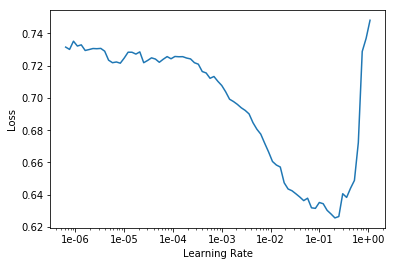

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.save('init_av_clf1')

In [10]:
exp1=IPyExperimentsPytorch()
learn.fit_one_cycle(1, slice(1e-03, 1e-02))


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1070 (8117 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2513 57817  64352 MB   3.91% 
GPU:  2230  5887   8117 MB  27.47% 




epoch,train_loss,valid_loss,accuracy
1,0.640155,0.667220,0.608108


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:42.084
･ CPU:         0       3     2513 MB |
･ GPU:      -707    6542     1522 MB |


In [11]:
learn.fit_one_cycle(1, slice(1e-03, 1e-02), wd=1e-04)

epoch,train_loss,valid_loss,accuracy
1,0.500654,0.633654,0.633205


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:42.416
･ CPU:         0       3     2513 MB |
･ GPU:       -12    6398     1510 MB |


In [12]:
learn.fit_one_cycle(1, slice(1e-03, 1e-02), wd=1e-04)

epoch,train_loss,valid_loss,accuracy
1,0.451643,0.999028,0.577220


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:44.458
･ CPU:         0       3     2513 MB |
･ GPU:        16    6494     1526 MB |


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


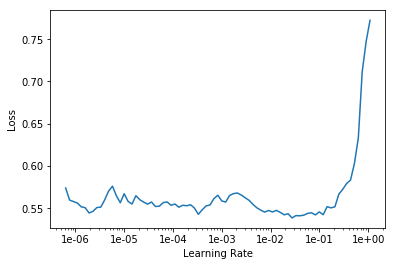

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.save('avclf_1')

In [17]:
learn.fit_one_cycle(3, slice(5e-2))

epoch,train_loss,valid_loss,accuracy
1,0.607003,0.713487,0.594595
2,0.587321,0.726404,0.594595


KeyboardInterrupt: 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))


epoch,train_loss,valid_loss,accuracy


RuntimeError: CUDA out of memory. Tried to allocate 40.50 MiB (GPU 0; 7.93 GiB total capacity; 3.47 GiB already allocated; 34.94 MiB free; 52.29 MiB cached)